# Assignment 3 

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>


## Importing packages

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import gymnasium as gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import os


os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
rnd = np.random.default_rng(112233)

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Building Cart Pole Q-learning

In [2]:
env = gym.make('CartPole-v1')

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Building Q-learning class

In [3]:
class qlearning:
    def __init__(self, env, alpha=.85, gamma=.95, epsilon=.1, bins=10,penalty=250,lr_model=None):
        self.a = alpha
        self.g = gamma
        self.e = epsilon
        self.n_bins = bins
        self.env = env
        self.penalty = penalty
        self.greedy=False
        self.lr_model = lr_model
        
        # changing bounds into more compact values to speed up training (fewer bins needed for this accuracy):
        self.env_space = [[3, -3],
                          [6, -6],
                          [0.300, -0.300],
                          [5, -5]]

        self.q = self.gen_table()
        
        return

    def gen_table(self):
        action_dim = self.env.action_space.n

        table = np.random.uniform(low=-0.001, high=0.001, size=(self.n_bins, self.n_bins, self.n_bins, self.n_bins, action_dim))

        self.q = table
        return self.q

    def update(self, reward, state, action, next_state):
        a, b, c, d, e = self.get_s(state, action)
        a_, b_, c_, d_ = self.get_s(next_state)

        self.q[a][b][c][d][e] = self.q[a][b][c][d][e] + self.a * (
                reward + self.g * np.max(self.q[a_][b_][c_][d_]) - self.q[a][b][c][d][e])

        return None
    
    def offline_update(self, reward, state, action, next_state):
        a, b, c, d, e = self.get_s(state, action)
        a_, b_, c_, d_ = self.get_s(next_state)

        return None

    def choose(self, state,imitation=False):

        if imitation:
            return int(self.lr_model.predict(np.array(state).reshape((1,-1)))[0])
        
        if (rnd.random() < self.e) and (self.greedy):
            # random sampling
            chosen = rnd.choice(list(range(self.env.action_space.n)))
        else:
            # greedy choice
            table = self.q
            for miniState in self.get_s(state):
                table = table[miniState]

            chosen = np.argmax(table)
        return chosen
    
    def get_max(self,table,state):
        for miniState in self.get_s(state):
                table = table[miniState]

        chosen = np.argmax(table)
        return table[chosen], chosen

    def get_s(self, state, action=None):
        indexes = []
        for i, feature in enumerate(state):
            max_value = self.env_space[i][0]
            min_value = self.env_space[i][1]

            if (feature > max_value) or (feature < min_value):
                raise ValueError(
                    f"Feature out of bounds for feature{str(i)} on bins : {str(feature)}  |min : {str(min_value)} - "
                    f"max :{str(max_value)}|")
            window_size = (max_value - min_value) / self.n_bins
            bin_loc = (feature - min_value) // window_size
            indexes.append(int(bin_loc))

        if action is None:
            return indexes
        else:
            return indexes + [action]
        

    def episode(self,imitation=False):
        state = self.env.reset()[0]
        ended = False
        ep_reward = 0
        ep_history = []

        while not ended:

            action = self.choose(state,imitation=imitation)

            # take A from S and get S'
            new_state, reward, ended, time_limit, prob = env.step(action)

            if ended:
                reward -= self.penalty

            self.update(reward, state, action, new_state)
            
            
            ep_history.append(np.array([x for x in state] + [action] +[y for y in new_state] + [reward]))

            # S <- S'
            state = new_state
            ep_reward += reward
            if time_limit:
                break

        return ep_reward,np.array(ep_history)
    
    def offline_train(self, data, k=10):
        
        weights = np.zeros((self.n_bins, self.n_bins, self.n_bins, self.n_bins, self.env.action_space.n))
        
        for epoch in range(k):
            total_error = 0
            for batch in np.array_split(data, 10):
                
                grad = np.zeros_like(weights)

                for index, row in batch.iterrows():
                    state = list(row[['s1','s2','s3','s4']])
                    next_state = list(row[['ns1','ns2','ns3','ns4']])
                    action = row['action']
                    r = row['reward']

                    Q_next = self.get_s(next_state) # get choices for the next state
                    max_Q_next = np.max(Q_next)
                    target = r + self.gamma * max_Q_next
                    
                    Q_predicted = self.get_s(state, action) # get the current value for the state with action
                    # we want to approximate the next to the current one and then 
                    
                    # calculating the squared error for  this data_point
                    error = (Q_predicted - target)**2



        
        
        return 
    
    # train
    def train(self, episode_n=1000, verbose=False,use_model=False):
        run_results = []
        for i, mode in enumerate(range(episode_n)):
            if verbose and (len(run_results) > 1):
                print(f"\n{i + 1}th Segment: {np.mean(run_results)} avg reward", end='')
            reward, history = self.episode()
            run_results.append(reward)

        return run_results
    
    def gen_data(self,episodes=500,imitation=False,reward_=False):
        self.greedy = True
        
        history_results = []
        reward_results = []
        for i in range(episodes):
            reward, history =  self.episode(imitation=imitation)
            for ep in history:
                history_results.append(ep)
            reward_results.append(reward)
        
        self.greedy = False
        if reward_:
            return reward_results, history_results
        else:
            return history_results
    


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Training the expert system

In [4]:
# picking best configurations from last assignment
n_bins = 10

epsilon = .15
learning_rate = 1 / 4

#setting one default rng for numpy 
rnd = np.random.default_rng(112233)


In [5]:
# expert model

if not os.path.exists('Data'):
    os.mkdir('Data')

if not os.path.exists(f'Data/Data{str(500)}.csv'):
    model = qlearning(env, alpha=learning_rate, epsilon=epsilon, bins=n_bins)
    _ = model.train(episode_n=10000)

# random model
if not os.path.exists(f'Data_random/Data{str(500)}.csv'):
    random_model = qlearning(env, alpha=learning_rate, epsilon=1, bins=n_bins)
    _ = random_model.train(episode_n=10000)
    

In [6]:
# Generating Data for the normal greedy model

for size in [100,250,500]:
    if not os.path.exists(f'Data/Data{str(size)}.csv'):
        data = np.array(model.gen_data(size))
        df = pd.DataFrame(data, columns=['s1','s2','s3','s4', 'action', 'ns1','ns2','ns3','ns4', 'reward'])
        df.to_csv(f'Data/Data{str(size)}.csv', index=False, sep=';', encoding='utf-8') # saving data
    else:
        df = pd.read_csv(f'Data/Data{str(size)}.csv', sep=';', encoding='utf-8')
    
    

In [7]:
# Generating Data for the random  model
if not os.path.exists('Data_random'):
    os.mkdir('Data_random')
    
for size in [100,250,500]:
    if not os.path.exists(f'Data_random/Data{size}.csv'):
        data = np.array(random_model.gen_data(size))
        df_random = pd.DataFrame(data, columns=['s1','s2','s3','s4', 'action', 'ns1','ns2','ns3','ns4', 'reward'])
        df_random.to_csv(f'Data_random/Data{size}.csv', index=False, sep=';', encoding='utf-8') # saving data
    else:
        df_random = pd.read_csv(f'Data_random/Data{size}.csv', sep=';', encoding='utf-8')


In [8]:
# data snippet
df.head(5)

,s1,s2,s3,s4,action,ns1,ns2,ns3,ns4,reward
0,-0.009218,-0.005560,0.028277,0.021064,1.0,-0.009329,0.189145,0.028698,-0.262565,1.0
1,-0.009329,0.189145,0.028698,-0.262565,0.0,-0.005546,-0.006374,0.023447,0.039030,1.0
2,-0.005546,-0.006374,0.023447,0.039030,1.0,-0.005673,0.188404,0.024228,-0.246164,1.0
3,-0.005673,0.188404,0.024228,-0.246164,0.0,-0.001905,-0.007056,0.019304,0.054061,1.0
4,-0.001905,-0.007056,0.019304,0.054061,1.0,-0.002046,0.187784,0.020386,-0.232469,1.0


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>


## Preparing data split

In [9]:
sizes = [100, 250, 500]
splits = [(1.0,.0), (.5,.5), (.0,1.0)]

datasets = {100:{},250:{},500:{}}

for size in sizes:
    for split in splits:
        x = df.sample(int(size*split[1]))
        y = df_random.sample(int(size*split[0]))
        datasets[size][split] = pd.concat([x,y])


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>


## Imitation learning

In [10]:
# creating the logistic regression model for the immitation

immitation_models = {100:{},250:{},500:{}}

for size in sizes:
    for split in splits:
        data = datasets[size][split]
        y = data['action']
        X = data[['s1','s2','s3','s4']]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
        lr = LogisticRegression(random_state=0,max_iter=500,multi_class='multinomial').fit(X_train.values,y_train.values)
#         print(lr.score(X_test, y_test))

        # now creating immitation model with the log regress 
        model = qlearning(env, alpha=learning_rate, epsilon=epsilon, bins=n_bins,lr_model=lr)
        immitation_models[size][split] = model
        

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>


### Evaluating models

In [11]:
model = immitation_models[500][(.0,1.0)]
test_result = model.gen_data(episodes=100,imitation=True, reward_=True)[0]

# compensating penalty for the purpose of visualization (normally all non-sucessfull would have an penalty)
test_result = [x if x==500 else x+250 for x in test_result]

Text(0, 0.5, 'Runs')

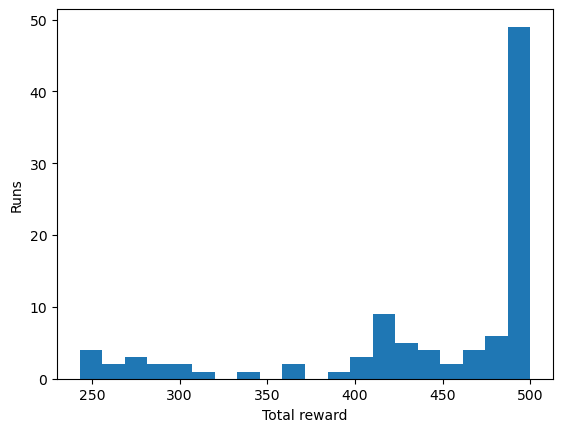

In [12]:
plt.hist(test_result,bins=20)
plt.xlabel("Total reward")
plt.ylabel("Runs")

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>


## Training fitted Q-learning

In [13]:
# hyper-params

K = 10
learning_rates = [.25, .5]
epsilon = 0


In [ ]:
# fitted model
data = datasets[500][(.0,1.0)]
model = qlearning(env)
model.offline_train(data)

## Discussion
